<a href="https://colab.research.google.com/github/MElena14/COMP341/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - Group 4
Welcome to our colab environment to train an agent to play Atari 2600 games! <br>
In this assignment, we train an agent to play the Atari game "Atlantis" and we achieve high scores comparable to the authors of the double DQN paper.
<br>
To see our agent in action, simply "Run All" then scroll to the bottom and see!

In [1]:
model = 'ResNetDQN' # options are 'DQNcnn' or 'ResNetDQN' (Hint: ResNetDQN is better!)

### Imports and initialisations

#### imports

In [2]:
import random
import math
from collections import deque, namedtuple
from os.path import exists
import cv2
import pickle
from tqdm.notebook import tqdm
import PIL

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

import gym

#### download pre-trained model file

In [3]:
!wget https://raw.githubusercontent.com/MElena14/COMP341/main/atari_atlantas_dqn.policy.net
!wget https://raw.githubusercontent.com/MElena14/COMP341/main/atari_atlantas_dqn.target.net
!wget https://raw.githubusercontent.com/MElena14/COMP341/main/atari_atlantas_resnetDqn.policy.net
!wget https://raw.githubusercontent.com/MElena14/COMP341/main/atari_atlantas_resnetDqn.target.net

--2022-05-04 15:31:39--  https://raw.githubusercontent.com/MElena14/COMP341/main/atari_atlantas_dqn.policy.net
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6747655 (6.4M) [application/octet-stream]
Saving to: ‘atari_atlantas_dqn.policy.net.3’

atari_atlantas_dqn. 100%[===================>]   6.43M  --.-KB/s    in 0.08s   

2022-05-04 15:31:39 (81.6 MB/s) - ‘atari_atlantas_dqn.policy.net.3’ saved [6747655/6747655]

--2022-05-04 15:31:39--  https://raw.githubusercontent.com/MElena14/COMP341/main/atari_atlantas_dqn.target.net
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP reques

#### Render OpenAI Gym Environments from CoLab

In [4]:
# HIDE OUTPUT
try:
    from google.colab import drive
    IN_COLAB = True
    device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
    env_name = "Atlantis-v0"
    !wget http://www.atarimania.com/roms/Roms.rar 
    !unrar x -o+ /content/Roms.rar >/dev/nul
    !python -m atari_py.import_roms /content/ROMS >/dev/nul

    !pip install gym pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

    !apt-get update > /dev/null 2>&1
    !apt-get install cmake > /dev/null 2>&1
    !pip install --upgrade setuptools 2>&1
    !pip install ez_setup > /dev/null 2>&1
    !pip install gym[atari] > /dev/null 2>&1
except:
    IN_COLAB = False
    env_name = "ALE/Atlantis-v5"
    print('not in colab')
    device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:1")
print("Using device", device)


--2022-05-04 15:31:40--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19583716 (19M) [application/x-rar-compressed]
Saving to: ‘Roms.rar.3’

Roms.rar.3          100%[===================>]  18.68M   638KB/s    in 31s     

2022-05-04 15:32:12 (619 KB/s) - ‘Roms.rar.3’ saved [19583716/19583716]

Using device cuda:0


In [5]:
def query_environment(name):
  env = gym.make(name)
  spec = gym.spec(name)
  print(f"Action Space: {env.action_space}")
  print(f"possible actions: {env.unwrapped.get_action_meanings()}")
  print(f"Observation Space: {env.observation_space}")
  print(f"Max Episode Steps: {spec.max_episode_steps}")
  print(f"Nondeterministic: {spec.nondeterministic}")
  print(f"Reward Range: {env.reward_range}")
  print(f"Reward Threshold: {spec.reward_threshold}")
  
query_environment(env_name)

Action Space: Discrete(4)
possible actions: ['NOOP', 'FIRE', 'RIGHTFIRE', 'LEFTFIRE']
Observation Space: Box(0, 255, (210, 160, 3), uint8)
Max Episode Steps: 10000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None


In [6]:
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

if IN_COLAB:
    display = Display(visible=0, size=(1400, 900))
    display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  print(mp4list[-1])
  if len(mp4list) > 0:
    mp4 = mp4list[-1]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

if IN_COLAB:
    from gym.wrappers import Monitor
    def wrap_env(env, record_every=1, folder='./video'):
        env = Monitor(env, folder, force=True)
        return env
else:
    from gym.wrappers.record_video import RecordVideo
    def wrap_env(env, record_every=1, folder='./video'):
        env = RecordVideo(env, folder, episode_trigger=lambda i: i % record_every == 0)
        return env


#### inital random agent

In [7]:
def show_random_agent():
  env = wrap_env(gym.make(env_name))

  observation = env.reset()
  score = 0
  while True:
      env.render()
      action = env.action_space.sample()
      observation, reward, done, info = env.step(action)
      score += reward
      if done:
        print(f"finished! random agent's score is {score}")
        break
  env.close()
  show_video()

### Let's see a random agent

In [8]:
show_random_agent()

finished! random agent's score is 36100.0
video/openaigym.video.0.4332.video000000.mp4


#### Deep QN

In [9]:
class DQNCnn(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential( # in = 84x84
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        ) # out = 7x7
        self.feature_size = 7 * 7 * 64

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    

#### ResNetDQN

##### ResNetBlock

In [10]:
class ResNetBlock(nn.Module):
    def __init__(self, depth_in, activation_func, depth_out=-1):
        super().__init__()
        self.downSampleResidul = True
        if depth_out == -1:
            depth_out = depth_in
            self.downSampleResidul = False

        self.resBlock = nn.Sequential(
            nn.BatchNorm2d(depth_in),
            activation_func(inplace=True),
            nn.Conv2d(depth_in, depth_out, kernel_size=3, padding=1, stride=1 if not self.downSampleResidul else 2, bias=False),
            nn.BatchNorm2d(depth_out),
            activation_func(inplace=True),
            nn.Conv2d(depth_out, depth_out, kernel_size=3, padding=1, bias=False)
        )

        self.downsampleRes = nn.Sequential(
            nn.BatchNorm2d(depth_in),
            activation_func(inplace=True),
            nn.Conv2d(depth_in, depth_out, kernel_size=1, stride=2, bias=False)
        )

    def forward(self, x):
        z = self.resBlock(x)
        if self.downSampleResidul:
            x = self.downsampleRes(x)
        return z + x

##### ResNetDQN

In [11]:
class ResNetDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        self.input_shape = input_shape
        self.num_actions = num_actions
        super(ResNetDQN, self).__init__()
        self.block1 = nn.Sequential(    #in = 159x159
            nn.Conv2d(input_shape[0], 16, kernel_size=3, stride=2, padding=0), #out = 79x79
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0), #out = 77x77
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0), #out = 75x75
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0) #out = 37x37
        )
        self.featureExtractionBlock = nn.Sequential(
            ResNetBlock(32, nn.SiLU, 64),  #out = 19x19
            ResNetBlock(64, nn.SiLU),      #out = 19x19
            ResNetBlock(64, nn.SiLU),      #out = 19x19 
            ResNetBlock(64, nn.SiLU, 128), #out = 10x10
            ResNetBlock(128, nn.SiLU),     #out = 10x10
        )
        self.flattened_size = 128 * 10 * 10
        self.regressionBlock = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.flattened_size, 1024),
            nn.Dropout(0.2),
            nn.SiLU(inplace=True),
            nn.Linear(1024, self.num_actions),
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.featureExtractionBlock(x)
        x = x.view(-1, self.flattened_size)
        x = self.regressionBlock(x)
        return x

#### utils

In [12]:
# modified from https://github.com/deepanshut041/Reinforcement-Learning/blob/master/algos/preprocessing/stack_frame.py
def preprocess_frame(screen, exclude, output):
    """Preprocess Image.
        
        Params
        ======
            screen (array): RGB Image
            exclude (tuple): Section to be croped (UP, RIGHT, DOWN, LEFT)
            output (int): Size of output image
        """
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    #Crop screen[Up: Down, Left: right] 
    screen = screen[exclude[0]:exclude[2], exclude[3]:exclude[1]]
    
    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = cv2.resize(screen, (output, output), interpolation = cv2.INTER_AREA)
    return screen

def stack_frame(stacked_frames, frame, is_new):
    """Stacking Frames.
        
        Params
        ======
            stacked_frames (array): Four Channel Stacked Frame
            frame: Preprocessed Frame to be added
            is_new: Is the state First
        """
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame
    
    return stacked_frames

frame_crops = {'DQNcnn': 84, 'ResNetDQN': 159}

def get_stack_frames(net='DQNcnn'):
    size = frame_crops[net]
    def stack_frames(frames, state, is_new=False):
        frame = preprocess_frame(state, (0, -10, -100, 9), size)
        frames = stack_frame(frames, frame, is_new)
        return frames
    return stack_frames

def show_cropped_image():
    env = gym.make(env_name)
    observation = env.reset()
    t, done = 0, False
    while not done and t < 260:
      # env.render()
      action = env.action_space.sample() 
      observation, reward, done, info = env.step(action)
      
      t += 1
                                # (UP, RIGHT, DOWN, LEFT)
    f = preprocess_frame(observation, (0, -10, -100, 9), 159)
    return PIL.Image.fromarray(np.uint8(f * 255), mode="L")

In [13]:
def plot_epsilon_func(eps_func, n_episodes=1000):
    episodes = range(n_episodes)
    eps = [eps_func(i) for i in episodes]
    plt.plot(episodes, eps)
    plt.show()

def iqr_mean(scores):
    scores = np.array(scores)
    q25, q75 = np.percentile(scores, [25, 75])
    meaners = scores[np.logical_and(scores > q25, scores < q75)]
    return q25, q75, meaners.mean()

#### show input frame

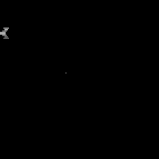

In [14]:
show_cropped_image()

### memory

In [15]:
# Experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
from numpy.typing import NDArray
class ReplayMemory:
    def __init__(self, buffer_size, batch_size, device, filename=None, top=1):
        self.memory = deque(maxlen=buffer_size) if filename is None else pickle.load(open(filename, 'rb'))
        self.batch_size = int(batch_size/top) if top < 1 else batch_size
        self.top = top
        self.device = device
        self.mean = lambda l: sum(l)/len(l)
    def add(self, state, action, reward, next_state, done):
        Experience = (state, action, reward, next_state, float(done))
        self.memory.append(Experience)
    def _as_tensor(self, np_array:NDArray, dtype=torch.float):
        tensor = torch.from_numpy(np.array(np_array))
        return tensor.type(dtype, non_blocking=True).to(self.device, non_blocking=True)
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        if self.top < 1:
            experiences.sort(key=lambda e:e[2], reverse=True)
            experiences = experiences[:int((self.top*self.batch_size))]
        states, actions, rewards, next_states, dones = zip(*experiences)
        states, next_states = self._as_tensor(states), self._as_tensor(next_states)
        actions, rewards, dones = self._as_tensor(actions, dtype=torch.int64), self._as_tensor(rewards), self._as_tensor(dones, dtype=torch.uint8)
        return (states, actions, rewards, next_states, dones)
        

    def save(self, filename):
        pickle.dump(self.memory, open(filename, 'wb') )

    def __len__(self):
        return len(self.memory)

### Agent

In [16]:
class DQNAgent:
    def __init__(self, args):
        self.input_shape = args['input_shape']
        self.action_size = args['action_size']
        self.device = args['device']
        self.buffer_size = args['buffer_size']
        self.batch_size = args['batch_size']
        self.gamma = args['gamma']
        self.lr = args['lr']
        self.learn_every = args['learn_every']
        self.replay_after = args['replay_after']
        self.network = args['model']
        self.tau = args['tau']
        self.base_filename = args['base_filename']
        episodes = args['episodes'] if 'episodes' in args else 10000
        
        
        # Q-Network
        self.policy_net = self.network(self.input_shape, self.action_size).to(self.device)
        self.target_net = self.network(self.input_shape, self.action_size).to(self.device)
        self.optimizer = torch.optim.AdamW(self.policy_net.parameters(), lr=self.lr)
        self.loss = nn.SmoothL1Loss()
        self.losses = torch.zeros(int(episodes/self.learn_every+2)).to(self.device)
        self.nextLossIdx = torch.tensor([0],dtype=torch.uint8).to(self.device)

        self.memoryTop = args['memory_top'] if 'memory_top' in args else False
        self.memory = ReplayMemory(self.buffer_size, self.batch_size, self.device, top=self.memoryTop)
        
        self.time_step = 0

    def save(self):
        torch.save(self.policy_net.state_dict(), f"{self.base_filename}.policy.net")
        torch.save(self.target_net.state_dict(), f"{self.base_filename}.target.net")
        self.memory.save(f"{self.base_filename}.memory")

    def load(self):
        if exists(f"{self.base_filename}.memory"):
            self.memory = ReplayMemory(self.buffer_size, self.batch_size, self.device, f"{self.base_filename}.memory", top=self.memoryTop)
        self.policy_net.load_state_dict(torch.load(f"{self.base_filename}.policy.net", map_location=self.device))
        self.target_net.load_state_dict(torch.load(f"{self.base_filename}.target.net", map_location=self.device))

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every "learn_every" time steps.
        self.time_step = (self.time_step + 1) % self.learn_every
        if self.time_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.replay_after:
                experiences = self.memory.sample()
                self.learn(experiences)


    def act(self, state, eps=0.):
        if torch.rand(1).item() < eps: # Epsilon-greedy action selection
            return torch.randint(self.action_size, (1,)).item(), 2
        
        self.policy_net.eval() # set the model to evaluation mode
        with torch.no_grad():
            state = torch.from_numpy(state).unsqueeze(0).to(self.device)
            action_values = self.policy_net(state)
            action_selection = action_values.detach().argmax().cpu().numpy()
        self.policy_net.train() # set the model back to training mode
        return action_selection, 1
            
    def learn(self, experiences): #input = 1 mini-batch
        states, actions, rewards, next_states, dones = experiences

        # Get expected Q values from the policy, and max predicted Q values from the target
        Q_expected = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        targets_next = self.target_net(next_states).detach().max(dim=1)[0]
        
        # Calculate the Q value
        # Multiply by (1 - done) to zero out the next state Q values if the game ended.
        Q_targets = rewards + (self.gamma * targets_next * (1 - dones))
        
        # optimise the model, by minimising the loss
        loss = self.loss(Q_expected, Q_targets)
        self.losses[self.nextLossIdx.item()] = loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.policy_net, self.target_net, self.tau)
    
    def soft_update(self, policy_model, target_model, tau):
        for target_param, policy_param in zip(target_model.parameters(), policy_model.parameters()):
            target_param.data.copy_(tau*policy_param.data + (1.0-tau)*target_param.data)

# our implimentation is based on https://github.com/deepanshut041/Reinforcement-Learning/blob/master/algos/agents/dqn_agent.py
# we have improved this implimentation and added load and save functions


### training functions

In [17]:
def epsilon_decrease_func(start, end, decay):
    def epsilon_decrease(i):
        return end + (start - end) * math.exp(-1. * i / decay)
    return epsilon_decrease

In [18]:
def trainDQN(agent: DQNAgent, epsilon_decrease, env, n_episodes=1000, network='DQNcnn', start_epoch = 0, save_every=100, plot_every=500, log_eps=False):
    print(f"Training for {n_episodes} episodes, train every {agent.learn_every} episodes = {int(n_episodes/agent.learn_every)} train epoch")
    scores = []
    stack_frames = get_stack_frames(network)
    for i_episode in range(start_epoch + 1, start_epoch + n_episodes + 1):
        state = stack_frames(None, env.reset(), is_new=True)
        score, done = 0, False
        eps = epsilon_decrease(i_episode)
        while not done:
            action, _ = agent.act(state, eps)
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, is_new=False)
            agent.step(state, action, reward, next_state, done)
            state = next_state
        scores.append(score)

        print(f'\rEpisode {i_episode}\tScore: {scores[-1]}\tAverage Score: {round(np.mean(scores[-20:]), 2)}\t eps:{round(eps, 2)}\t ', end="") #log_eps_str
        
        if i_episode % plot_every == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores[-plot_every:])}')
            _ = plt.hist(scores[-plot_every:], bins=30)
            plt.show()
            evalDQN(agent, 0.1, n_episodes=50,  network=network)
        if i_episode % save_every == 0:
            agent.save()
    agent.save()
    return scores

def evalDQN(agent, eps, env, n_episodes=50,  network='DQNcnn'):
    scores = []
    stack_frames = get_stack_frames(network)
    high_score, high_score_action_types = 0, (0.0,0.0)
    for i_episode in range(n_episodes):
        state = stack_frames(None, env.reset(), is_new=True)
        score, done = 0, False
        actionTypes, actionTypesIdx = np.zeros(50000, dtype=np.uint8), 0
        while not done:
            action, actionType = agent.act(state, eps)
            actionTypes[actionTypesIdx] = actionType
            actionTypesIdx += 1
            next_state, reward, done, info = env.step(action)
            score += reward
            state = stack_frames(state, next_state, is_new=False)
        scores.append(score)
        if score > high_score:
            high_score = score
            high_score_action_types = (np.count_nonzero(actionTypes == 2)/actionTypesIdx, np.count_nonzero(actionTypes == 1)/actionTypesIdx) 
        log_eps_str = f'rand({round(np.count_nonzero(actionTypes[actionTypes == 2])/actionTypesIdx,2)}) neural({round(np.count_nonzero(actionTypes[actionTypes == 1])/actionTypesIdx,2)})    '
        print(f'\rEpisode {i_episode+1}\tScore: {round(scores[-1])}\tAverage Score: {round(np.mean(scores[-n_episodes:]), 1)}\t eps:{round(eps, 2)}\t {log_eps_str}', end="")
    print(f'\n eval:\navg score: {np.mean(scores)}  high score: {np.max(scores)} low score: {np.min(scores)}')
    iqr25, iqr75, iqrAvg = iqr_mean(scores)
    print(f"interquatile range ({iqr25} -> {iqr75}) mean = {round(iqrAvg, 2)}")
    print(f'high score: {high_score}, rand: {round(high_score_action_types[0]*100, 1)}% neural net: {round(high_score_action_types[1]*100,1)}%')
    return scores


### run

In [19]:
Number_of_episodes = 20000
save_models_every = 250
train_every = 20

#### training runner

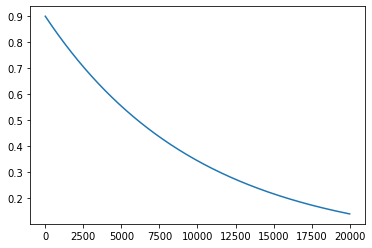

In [20]:
env = wrap_env(gym.make(env_name), record_every=1000)

agent_args = {
            'input_shape': (4, frame_crops[model], frame_crops[model]),
            'action_size': env.action_space.n,
            'device': device,
            'buffer_size': 1000000,
            'batch_size': 64,
            'gamma': 0.99,
            'lr': 1e-4,
            'tau': 1e-3,
            'learn_every': train_every,
            'replay_after': 10000,
            'memory_top': 0.1,
            'episodes': Number_of_episodes
        }

if model == 'DQNcnn':
    agent_args = {**agent_args, 'model': DQNCnn, 'base_filename': 'atari_atlantas_dqn'}
elif model == 'ResNetDQN':
    agent_args = {**agent_args, 'model': ResNetDQN, 'base_filename': 'atari_atlantas_resnetDqn'}
else:
    raise Exception('model not found')

epsilon_decrease = epsilon_decrease_func(start=0.9, end=0.02, decay=Number_of_episodes/2)
plot_epsilon_func(epsilon_decrease, Number_of_episodes)

#### Run

In [21]:
agent = DQNAgent(agent_args)
agent.load()
# scores = trainDQN(agent, epsilon_decrease, env, n_episodes=Number_of_episodes, save_every=save_models_every, plot_every=1000, network=model)

In [26]:
evalScores = evalDQN(agent, 0.05, env, n_episodes=100,  network=model)

Episode 100	Score: 17300	Average Score: 20266.0	 eps:0.05	 rand(0.05) neural(0.95)    
 eval:
avg score: 20266.0  high score: 51800.0 low score: 8700.0
interquatile range (14675.0 -> 24450.0) mean = 19184.0
high score: 51800.0, rand: 4.9% neural net: 95.1%


(8700.0, 14675.0, 24450.0, 19184.0, 20266.0, 51800.0)

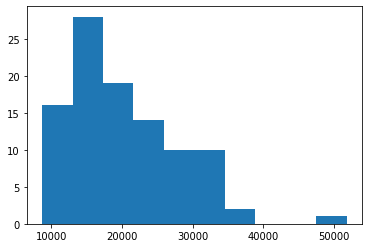

In [29]:
def get_score_avgs(scores):
    _ = plt.hist(scores, bins=10)
    q25, q75, iqMean = iqr_mean(scores)
    return np.min(scores), q25, q75, iqMean, np.mean(scores), np.max(scores)
get_score_avgs(evalScores)

In [23]:
def finalPlay(agent):
    stack_frames = get_stack_frames(model)
    env = wrap_env(gym.make(env_name))
    score = 0
    state = stack_frames(None, env.reset(), is_new=True)
    while True:
        env.render()
        action, _ = agent.act(state, eps=0.05)
        next_state, reward, done, _ = env.step(action)
        score += reward
        state = stack_frames(state, next_state, is_new=False)
        if done:
            print("Your Final score is:", score)
            break 
    env.close()
    show_video()
finalPlay(agent)

Your Final score is: 22700.0
video/openaigym.video.3.4332.video000000.mp4
